IMPORT DEPENDECIES

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchsummary import summary
import seaborn as sns
import numpy as np
import pandas as pd
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
from IPython import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# data augmentation with random crop and horizontal flip, and rotation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load the CIFAR-10 dataset
train_dataset =  torchvision.datasets.CIFAR10(root='train_data/', train=True, download=False, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='test_data/', train=False, download=False, transform=transform_test)

In [ ]:
batch_size = 128

# make a function to set the batch size of the dataloader
def set_batch_size(batch_size):
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, valloader, test_loader

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

trainloader, valloader, test_loader = set_batch_size(batch_size)

print('Train data size:', len(train_data))
print('Validation data size:', len(val_data))
print('Test data size:', len(test_dataset))

Train data size: 40000
Validation data size: 10000
Test data size: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape: torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
tensor([5, 0, 9, 4, 6, 4, 3, 3, 7, 0, 7, 9, 9, 6, 5, 4, 2, 6, 3, 3, 4, 8, 9, 4,
        7, 2, 9, 3, 4, 2, 5, 2, 4, 7, 3, 1, 6, 6, 4, 3, 1, 2, 0, 0, 1, 5, 9, 7,
        5, 0, 7, 3, 4, 1, 9, 9, 3, 5, 9, 0, 3, 1, 0, 5, 3, 2, 9, 5, 1, 9, 0, 9,
        2, 9, 4, 6, 0, 1, 3, 7, 0, 1, 6, 3, 2, 8, 4, 9, 0, 2, 0, 1, 7, 9, 1, 2,
        1, 2, 1, 0, 7, 5, 0, 7, 6, 0, 2, 9, 0, 7, 7, 4, 2, 8, 4, 9, 6, 4, 3, 0,
        6, 4, 7, 2, 3, 6, 8, 6])


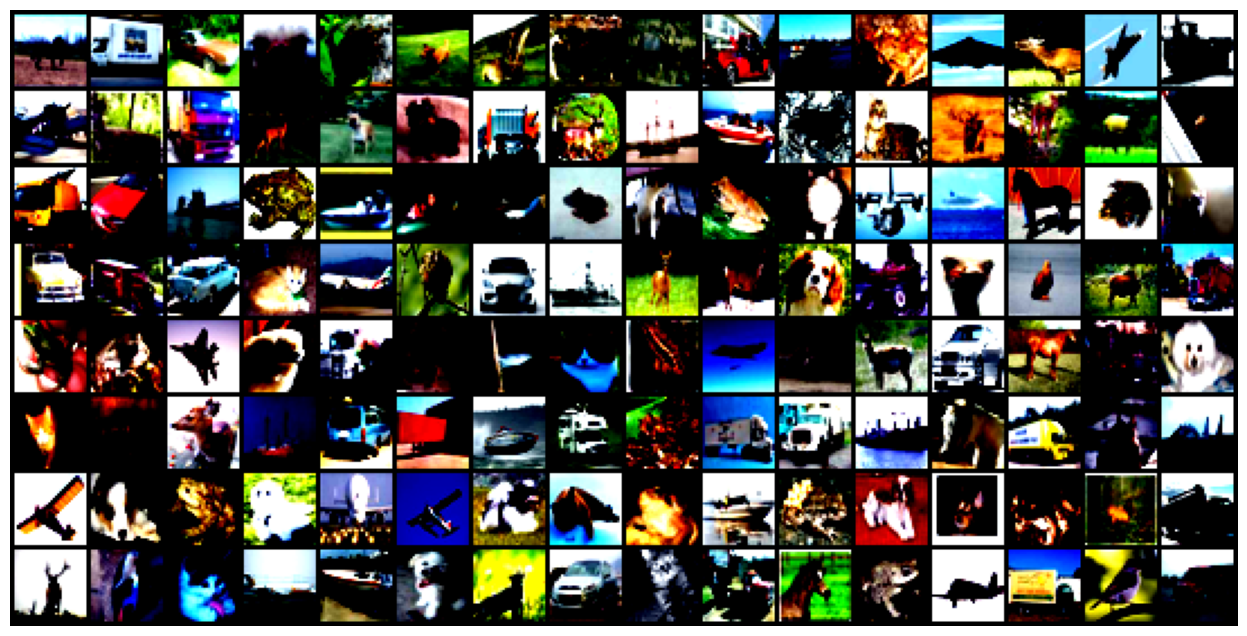

In [ ]:
# Show sample images
for images,_ in trainloader:
    print('images shape:' , images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

sample_image = iter(trainloader)
samples, labels = next(sample_image)
print(samples.shape)
print(labels)

In [ ]:
### MODEL TRAINER CLASS

# Save function
def save_checkpoint(model, optimizer, epoch, training_stats, total_time, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_stats': training_stats,  # Add training stats here
        'total_time': total_time  # Add total time here
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}")

def plot_learning_curve(training_stats):
    """Plots the training and validation results.

    Args:
        training_stats: A list of dictionaries containing training statistics.
                       Each dictionary should have the following keys:
                       'Epoch', 'Train_Loss', 'Train_Acc', 'Val_Acc', 'Val_Loss'.
    """
    if training_stats is None or len(training_stats) == 0:
        print("Training statistics not available. Train the model first.")
        return

    # Extract the statistics from the dictionary
    epochs = [stat['Epoch'] for stat in training_stats]
    train_losses = [stat['Train_Loss'] for stat in training_stats]
    val_losses = [stat['Val_Loss'] for stat in training_stats]
    train_accs = [stat['Train_Acc'] for stat in training_stats]
    val_accs = [stat['Val_Acc'] for stat in training_stats]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Training/Validation Loss
    axs[0].set_title("Training/Validation Loss over Epochs")
    axs[0].plot(epochs, train_losses, label="Training Loss", color="blue")
    axs[0].plot(epochs, val_losses, label="Validation Loss", color="orange")
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot Training/Validation Accuracy
    axs[1].set_title("Training/Validation Accuracy over Epochs")
    axs[1].plot(epochs, train_accs, label="Training Accuracy", color="blue")
    axs[1].plot(epochs, val_accs, label="Validation Accuracy", color="orange")
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

class ModelTrainer(nn.Module):

    def train_network(self, trainloader, valloader, num_epochs, criterion, optimizer):
        start_time = time.time()
        training_stats = []
        self.epochs = num_epochs
        self.stats_list = []
        early_stop = EarlyStopping(patience=2, min_delta=1)

        for epoch in range(0, num_epochs):
            self.train()
            batch_loss, batch_acc = [], []
            for i, batch_data in enumerate(trainloader, 0):
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                predictions = self(inputs)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()

            train_acc, train_loss = self.compute_acc_and_loss(trainloader, criterion)
            val_acc, val_loss = self.compute_acc_and_loss(valloader, criterion, mode="val")

            if early_stop.should_stop(val_loss):
                break

            epoch_stat = {"Epoch": epoch + 1, "Train_Loss": train_loss, "Train_Acc": train_acc, "Val_Acc": val_acc, "Val_Loss": val_loss}
            print(epoch_stat)
            training_stats.append(epoch_stat)

            #if epoch % 2 == 0 and epoch>0:
            #  elapsed_time = total_time + (time.time() - start_time)
            #  save_checkpoint(self, optimizer, epoch, training_stats, elapsed_time)

        self.stats_list = training_stats
        print('Training Completed')
        print(f"Total Time: {round((time.time() - start_time) / 60, 2)} minutes")

    def compute_acc_and_loss(self, loader, criterion, mode='train'):
        self.eval()
        loss_values, accuracy_list = [], []
        total_samples, correct_predictions = 0, 0
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                total_samples += labels.size(0)
                _, predicted_labels = torch.max(outputs.data, 1)
                correct_predictions += (predicted_labels == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_values.append(loss.item())
        mean_loss = np.mean(loss_values)
        accuracy = (100 * correct_predictions / total_samples)
        return accuracy, mean_loss

    def predict(self, testloader):
        self.eval()
        predictions_list = []
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                predictions_list.extend(predicted.cpu().numpy())
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of the network on the test data: {accuracy:.2f}%')
        return predictions_list, accuracy

    def class_accuracy(self, loader, classes):  # Add loader and classes as arguments
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))
        with torch.no_grad():
            for data in loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(len(labels)):  # len(labels) gives the batch size
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(len(classes)):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))

    def plot_training_results(self):
        train_accuracies = [x['Train_Acc'] for x in self.stats_list]
        val_accuracies = [x['Val_Acc'] for x in self.stats_list]
        train_losses = [x['Train_Loss'] for x in self.stats_list]
        val_losses = [x['Val_Loss'] for x in self.stats_list]

        # Create subplots with 1 row and 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot Training/Validation Loss
        axs[0].set_title("Training/Validation Loss over Epochs")
        axs[0].plot(np.arange(self.epochs), train_losses, label="Training Loss", color="blue")
        axs[0].plot(np.arange(self.epochs), val_losses, label="Validation Loss", color="orange")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot Training/Validation Accuracy
        axs[1].set_title("Training/Validation Accuracy over Epochs")
        axs[1].plot(np.arange(self.epochs), train_accuracies, label="Training Accuracy", color="green")
        axs[1].plot(np.arange(self.epochs), val_accuracies, label="Validation Accuracy", color="red")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy (%)')
        axs[1].legend()

        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()

class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = np.inf

    def should_stop(self, validation_loss):
        if validation_loss < self.min_val_loss:
            self.min_val_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#### BASELINE MODEL

In [ ]:
# define base model
class BaseModel(ModelTrainer):
    def __init__(self):
        super(BaseModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 10)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def forward(self, x):
        # Convolutional layer 1 followed by ReLU and pooling
        x = self.pool(self.relu(self.conv1(x)))

        # Convolutional layer 2 followed by ReLU and pooling
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layer 1 followed by ReLU and dropout
        x = self.relu(self.fc1(x))

        return x


In [ ]:
base_model = BaseModel().to(device)
summary(base_model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)
num_epochs = 20

base_model.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                   [-1, 10]          40,970
              ReLU-8                   [-1, 10]               0
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.84
Params size (MB): 0.23
Estimated Total Size (MB): 1.09
----------------------------------------------------------------
{'Epoch': 1, 'Train_Loss': 1.713130826767260

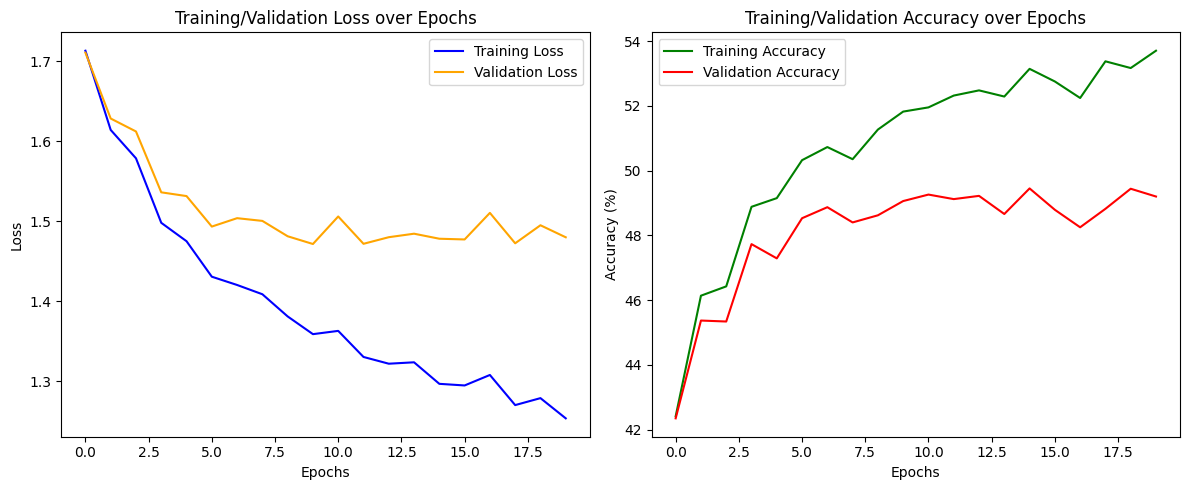

In [ ]:
base_model.plot_training_results()

In [ ]:
base_model.class_accuracy()

Accuracy of plane : 89.1891891891892 %
Accuracy of car : 94.28571428571429 %
Accuracy of bird : 0.0 %
Accuracy of cat : 0.0 %
Accuracy of deer : 81.57894736842105 %
Accuracy of dog : 90.9090909090909 %
Accuracy of frog : 0.0 %
Accuracy of horse : 95.45454545454545 %
Accuracy of ship : 86.20689655172414 %
Accuracy of truck : 0.0 %


In [ ]:
# add convolutional layer
class ModelNet1(ModelTrainer):
  def __init__(self):
    super(ModelNet1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64 * 4 * 4, 32)
    self.fc2 = nn.Linear(32,10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = x.view(-1, 64 * 4 * 4)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model_1 = ModelNet1().to(device)
summary(model_1, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
num_epochs = 20

model_1.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 32]          32,800
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330
Total params: 89,450
Trainable params: 

Accuracy of plane : 81.81818181818181 %
Accuracy of car : 91.66666666666667 %
Accuracy of bird : 54.54545454545455 %
Accuracy of cat : 61.53846153846154 %
Accuracy of deer : 76.0 %
Accuracy of dog : 53.333333333333336 %
Accuracy of frog : 85.71428571428571 %
Accuracy of horse : 78.78787878787878 %
Accuracy of ship : 81.81818181818181 %
Accuracy of truck : 87.5 %


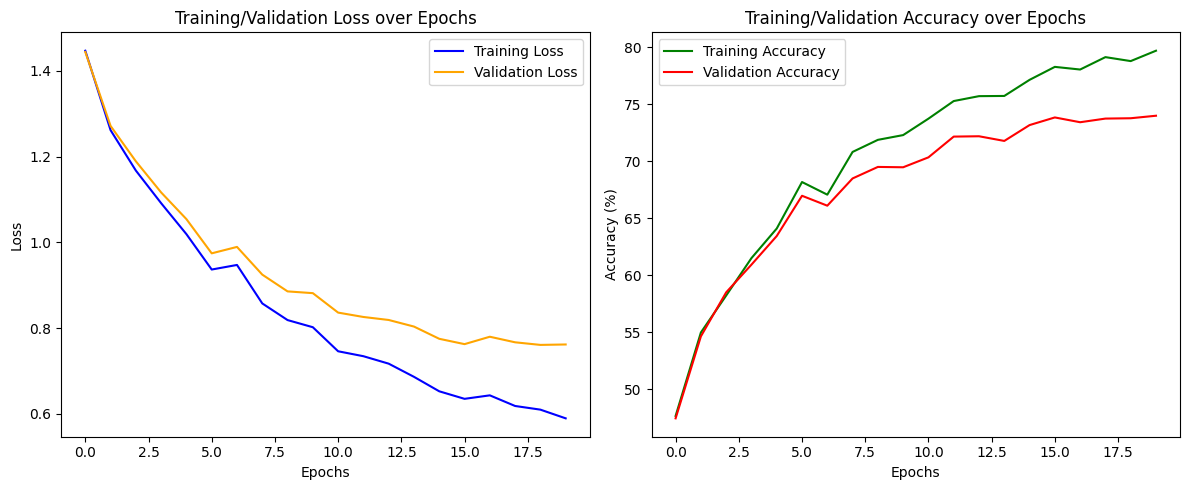

In [ ]:
model_1.class_accuracy()
model_1.plot_training_results()

In [ ]:
model_2 = ModelNet1().to(device)
summary(model_2, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

model_2.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 32]          32,800
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330
Total params: 89,450
Trainable params: 

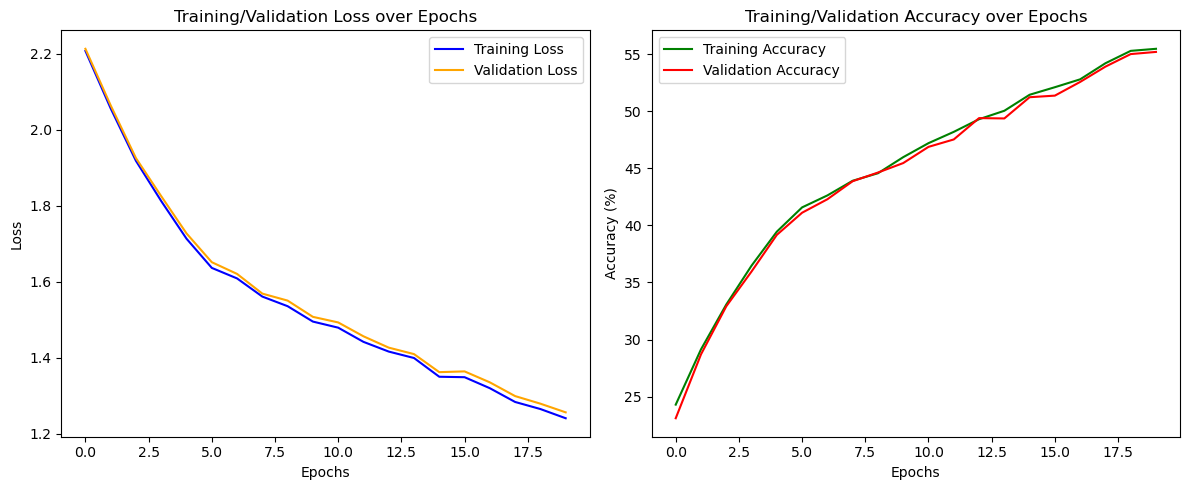

In [ ]:
model_2.plot_training_results()

In [ ]:
model_3 = ModelNet1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20

model_3.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

{'Epoch': 1, 'Train_Loss': 1.6844043411766758, 'Train_Acc': 38.5575, 'Val_Acc': 38.02, 'Val_Loss': 1.693411575088018}
{'Epoch': 2, 'Train_Loss': 1.5091961919309231, 'Train_Acc': 45.6175, 'Val_Acc': 45.23, 'Val_Loss': 1.5199616317507587}
{'Epoch': 3, 'Train_Loss': 1.335584694204239, 'Train_Acc': 53.19, 'Val_Acc': 52.29, 'Val_Loss': 1.3485248194465154}
{'Epoch': 4, 'Train_Loss': 1.1977997020410653, 'Train_Acc': 56.365, 'Val_Acc': 55.95, 'Val_Loss': 1.220232090618037}
{'Epoch': 5, 'Train_Loss': 1.1375850658066355, 'Train_Acc': 60.3, 'Val_Acc': 59.39, 'Val_Loss': 1.1593817208386674}
{'Epoch': 6, 'Train_Loss': 1.1371154451903445, 'Train_Acc': 61.035, 'Val_Acc': 60.38, 'Val_Loss': 1.1754524285280252}
{'Epoch': 7, 'Train_Loss': 1.0183501414978466, 'Train_Acc': 63.9, 'Val_Acc': 62.52, 'Val_Loss': 1.0658552269392376}
{'Epoch': 8, 'Train_Loss': 0.9523930153526818, 'Train_Acc': 66.8125, 'Val_Acc': 65.72, 'Val_Loss': 0.9912398216090624}
{'Epoch': 9, 'Train_Loss': 0.8682603698949845, 'Train_Acc': 6

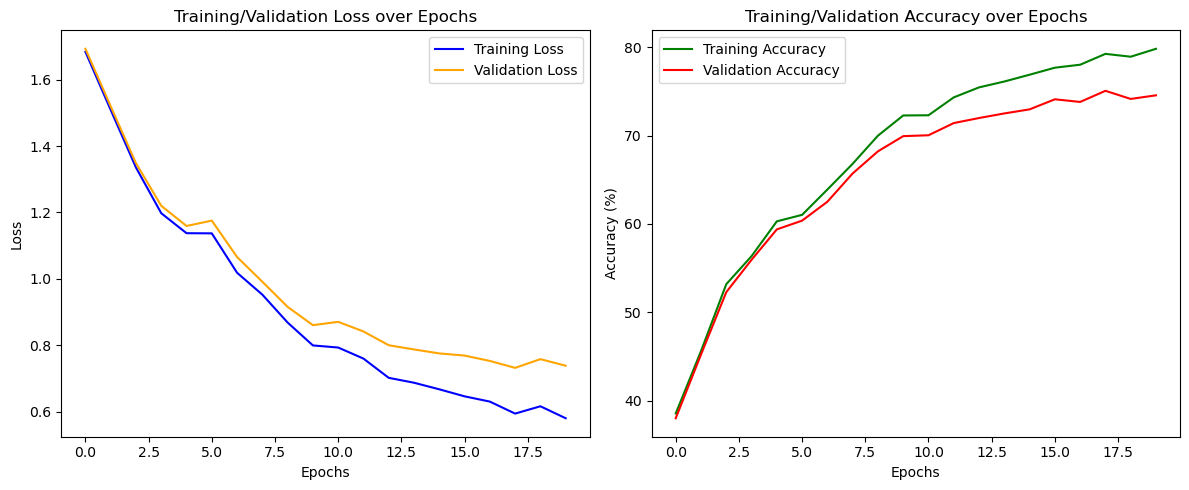

In [ ]:
model_3.plot_training_results()

In [ ]:
# make a cnn model to improve model 3
class ModelNet2(ModelTrainer):
  def __init__(self):
    super(ModelNet2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(128 * 2 * 2, 64)
    self.fc2 = nn.Linear(64,10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = self.pool(self.relu(self.conv4(x)))
    x = x.view(-1, 128 * 2 * 2)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model_4 = ModelNet2().to(device)
summary(model_4, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20

model_4.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         147,584
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                   [-1, 64]          32,832
             ReLU-14                   

Accuracy of plane : 57 %
Accuracy of   car : 66 %
Accuracy of  bird : 27 %
Accuracy of   cat : 70 %
Accuracy of  deer : 41 %
Accuracy of   dog : 21 %
Accuracy of  frog : 43 %
Accuracy of horse : 34 %
Accuracy of  ship : 37 %
Accuracy of truck : 78 %
Validation Accuracy: 48.18%


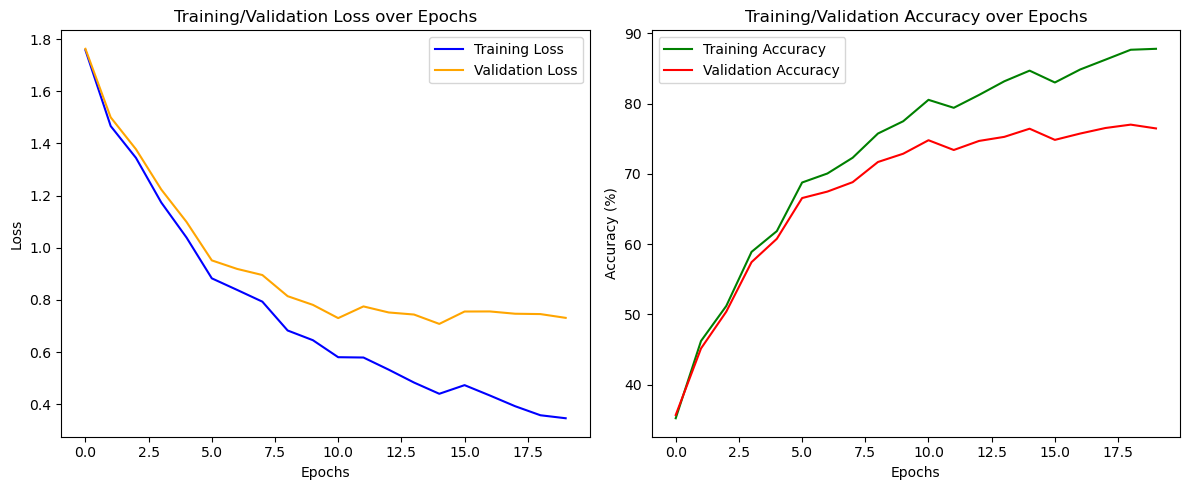

In [ ]:
model_4.class_accuracy(valloader, model_4.classes)
# calculate the total accuracy for validation set
val_acc, val_loss = model_4.compute_acc_and_loss(valloader, criterion, mode='val')
print(f'Validation Accuracy: {val_acc:.2f}%')
model_4.plot_training_results()


In [ ]:
# add more cnn layer and linear layer
class ModelNet3(ModelTrainer):
  def __init__(self):
    super(ModelNet3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(256 * 1 * 1, 128)
    self.fc2 = nn.Linear(128,10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = self.pool(self.relu(self.conv4(x)))
    x = self.pool(self.relu(self.conv5(x)))
    x = x.view(-1, 256 * 1 * 1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model_5 = ModelNet3().to(device)
summary(model_5, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_5.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20

model_5.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
             ReLU-11            [-1, 256, 4, 4]               0
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 256, 2, 2]         590,080
             ReLU-14            [-1, 25

Accuracy of plane : 56 %
Accuracy of   car : 74 %
Accuracy of  bird : 52 %
Accuracy of   cat : 47 %
Accuracy of  deer : 42 %
Accuracy of   dog : 28 %
Accuracy of  frog : 64 %
Accuracy of horse : 30 %
Accuracy of  ship : 64 %
Accuracy of truck : 60 %
Validation Accuracy: 52.65%


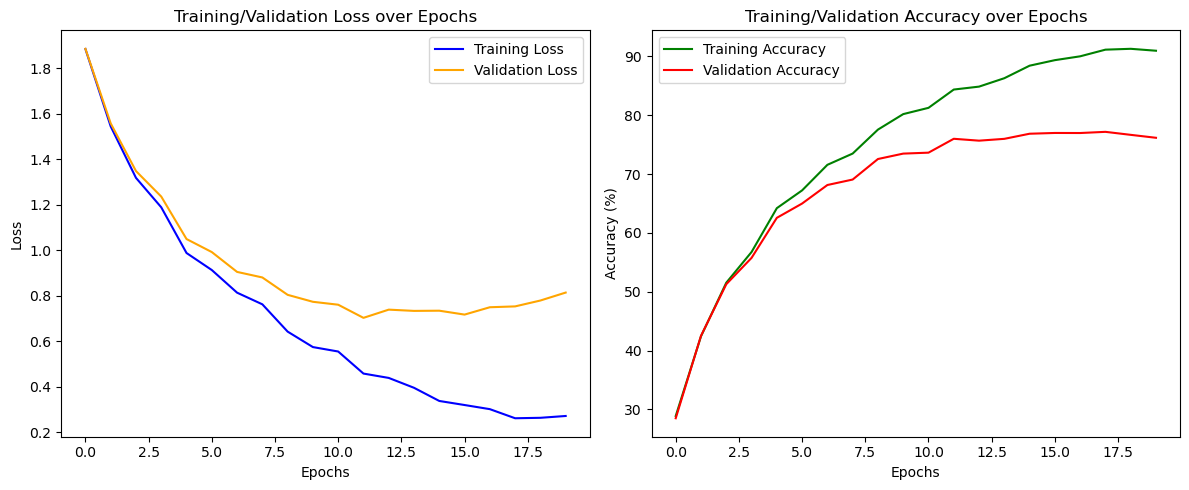

In [ ]:
model_5.class_accuracy(valloader, model_5.classes)
# calculate the total accuracy for validation set
val_acc, val_loss = model_5.compute_acc_and_loss(valloader, criterion, mode='val')
print(f'Validation Accuracy: {val_acc:.2f}%')
model_5.plot_training_results()


In [ ]:
# create more complex model with batch normalization and dropout
class ModelNet4(ModelTrainer):
  def __init__(self):
    super(ModelNet4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(256 * 1 * 1, 128)
    self.fc2 = nn.Linear(128,10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)
    self.bn5 = nn.BatchNorm2d(256)
    self.bn6 = nn.BatchNorm1d(128)
    self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  def forward(self, x):
    x = self.pool(self.relu(self.bn1(self.conv1(x))))
    x = self.pool(self.relu(self.bn2(self.conv2(x))))
    x = self.pool(self.relu(self.bn3(self.conv3(x))))
    x = self.pool(self.relu(self.bn4(self.conv4(x))))
    x = self.pool(self.relu(self.bn5(self.conv5(x))))
    x = x.view(-1, 256 * 1 * 1)
    x = self.relu(self.bn6(self.fc1(x)))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model_6 = ModelNet4().to(device)
summary(model_6, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_6.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30

model_6.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

Accuracy of plane : 87 %
Accuracy of   car : 94 %
Accuracy of  bird : 71 %
Accuracy of   cat : 60 %
Accuracy of  deer : 71 %
Accuracy of   dog : 67 %
Accuracy of  frog : 86 %
Accuracy of horse : 86 %
Accuracy of  ship : 72 %
Accuracy of truck : 76 %
Validation Accuracy: 77.20%


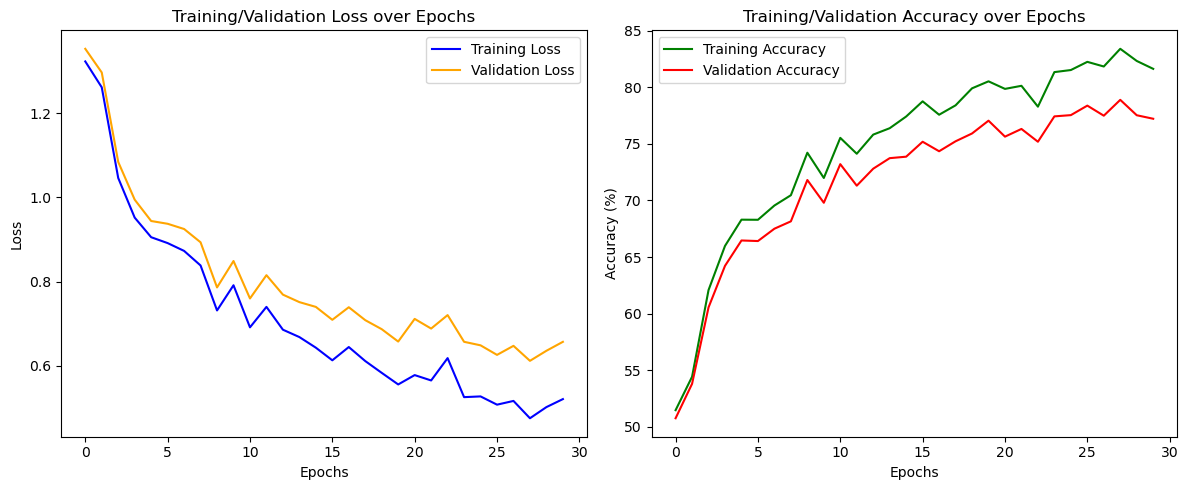

In [ ]:
model_6.class_accuracy(valloader, model_6.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_6.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_6.plot_training_results()

#### RESNET-18

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet18Trainer(ModelTrainer):
    def __init__(self, num_classes):
        super(ResNet18Trainer, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 consists of 4 layers with specific block and number of blocks in each layer
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [ ]:
model_resnet18 = ResNet18Trainer(num_classes=10).to(device)
summary(model_resnet18, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.001)
num_epochs = 20

model_resnet18.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
        BasicBlock-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,864
      BatchNorm2d-10             [-1, 64, 8, 8]             128
           Conv2d-11             [-1, 64, 8, 8]          36,864
      BatchNorm2d-12             [-1, 64, 8, 8]             128
       BasicBlock-13             [-1, 64, 8, 8]               0
           Conv2d-14            [-1, 12

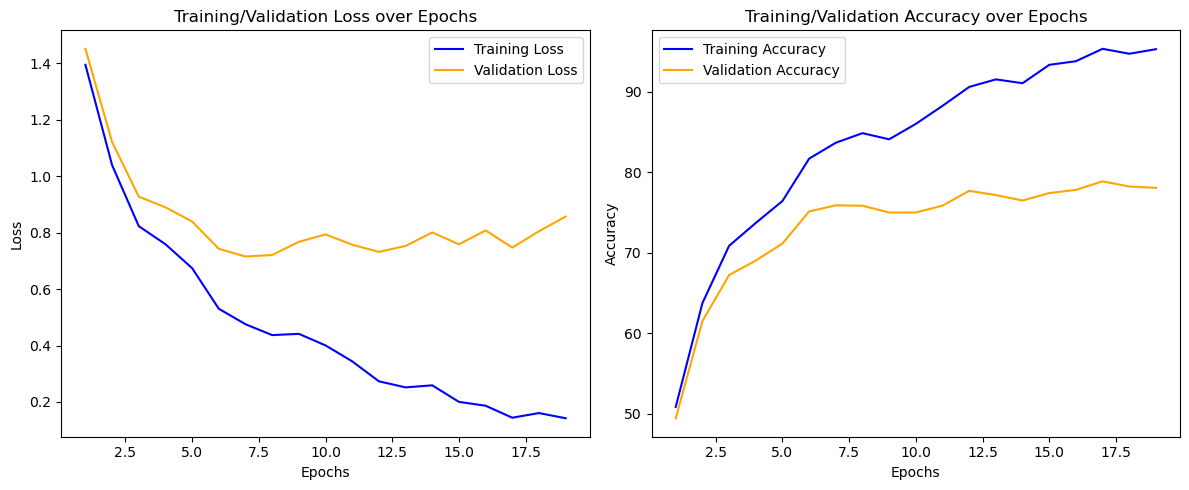

Accuracy of plane : 75 %
Accuracy of   car : 87 %
Accuracy of  bird : 78 %
Accuracy of   cat : 73 %
Accuracy of  deer : 74 %
Accuracy of   dog : 61 %
Accuracy of  frog : 79 %
Accuracy of horse : 78 %
Accuracy of  ship : 88 %
Accuracy of truck : 81 %
Validation Accuracy: 78.15%


In [ ]:
checkpoint = torch.load('checkpoint.pth')
training_stats = checkpoint['training_stats'][6:]
plot_learning_curve(training_stats)
model_resnet18.class_accuracy(valloader, model_resnet18.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")

In [ ]:
# Model resnet 18 with SGD
model_resnet18_sgd = ResNet18Trainer(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18_sgd.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

model_resnet18_sgd.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

{'Epoch': 1, 'Train_Loss': 1.2195047494321585, 'Train_Acc': 55.995, 'Val_Acc': 52.77, 'Val_Loss': 1.3133422106127195}
{'Epoch': 2, 'Train_Loss': 0.9799543779117231, 'Train_Acc': 64.69, 'Val_Acc': 59.49, 'Val_Loss': 1.1261162335359598}
{'Epoch': 3, 'Train_Loss': 0.8017989372293027, 'Train_Acc': 71.7225, 'Val_Acc': 64.42, 'Val_Loss': 1.017485503908954}
{'Epoch': 4, 'Train_Loss': 0.6862944024629867, 'Train_Acc': 75.935, 'Val_Acc': 66.91, 'Val_Loss': 0.9378327900850321}
{'Epoch': 5, 'Train_Loss': 0.6140022699634868, 'Train_Acc': 78.7825, 'Val_Acc': 67.5, 'Val_Loss': 0.9463695929020266}
{'Epoch': 6, 'Train_Loss': 0.5472422854397625, 'Train_Acc': 81.1875, 'Val_Acc': 68.44, 'Val_Loss': 0.9361877856375296}
{'Epoch': 7, 'Train_Loss': 0.4777542257461304, 'Train_Acc': 83.575, 'Val_Acc': 68.85, 'Val_Loss': 0.9314718465261822}
{'Epoch': 8, 'Train_Loss': 0.40324661649835, 'Train_Acc': 86.6075, 'Val_Acc': 69.82, 'Val_Loss': 0.9433479414710516}
{'Epoch': 9, 'Train_Loss': 0.37228961731679144, 'Train_Ac

In [ ]:
#model_resnet18_sgd.plot_training_results()
model_resnet18_sgd.class_accuracy(valloader, model_resnet18_sgd.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_sgd.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")


Accuracy of plane : 75 %
Accuracy of   car : 82 %
Accuracy of  bird : 59 %
Accuracy of   cat : 58 %
Accuracy of  deer : 73 %
Accuracy of   dog : 55 %
Accuracy of  frog : 72 %
Accuracy of horse : 77 %
Accuracy of  ship : 82 %
Accuracy of truck : 80 %
Validation Accuracy: 71.77%


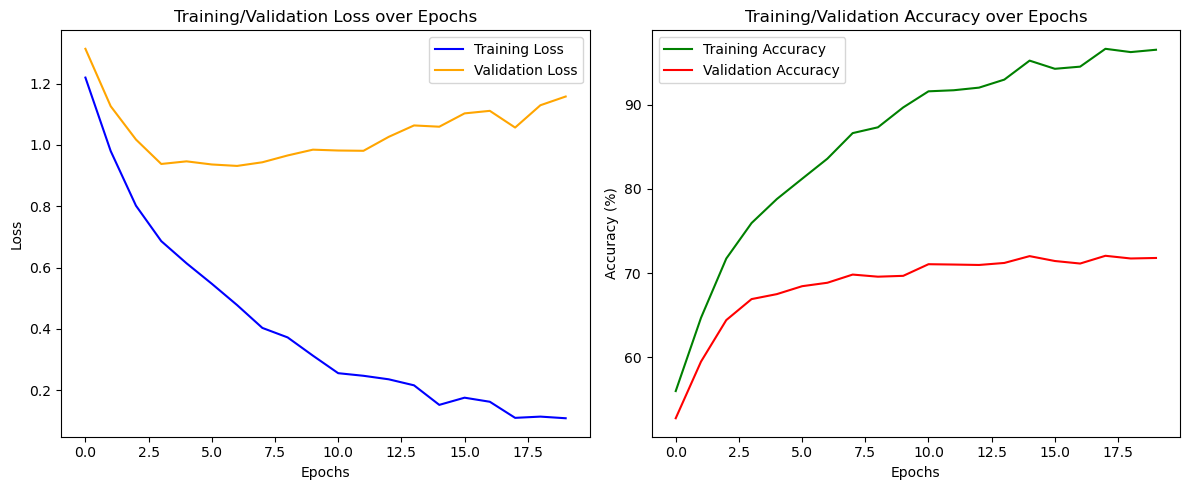

In [ ]:
model_resnet18_sgd.plot_training_results()

In [ ]:
# Resnet + dropout layer
class BasicBlock_DO(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(BasicBlock_DO, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        out = self.dropout(out)  # Apply dropout after the residual connection

        return out

class ResNet18Trainer_DO(ModelTrainer):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet18Trainer_DO, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(BasicBlock_DO, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlock_DO, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlock_DO, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlock_DO, 512, 2, stride=2, dropout_rate=dropout_rate)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock_DO.expansion, num_classes)

        # Final dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply final dropout before the output layer
        return self.fc(x)


In [ ]:
# Train the model with dropout
model_resnet18_do = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do.parameters(), lr=0.001)
num_epochs = 10

model_resnet18_do.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,864
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
    BasicBlock_DO-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Accuracy of plane : 76 %
Accuracy of   car : 81 %
Accuracy of  bird : 82 %
Accuracy of   cat : 60 %
Accuracy of  deer : 66 %
Accuracy of   dog : 38 %
Accuracy of  frog : 82 %
Accuracy of horse : 69 %
Accuracy of  ship : 89 %
Accuracy of truck : 86 %
Validation Accuracy: 73.75%


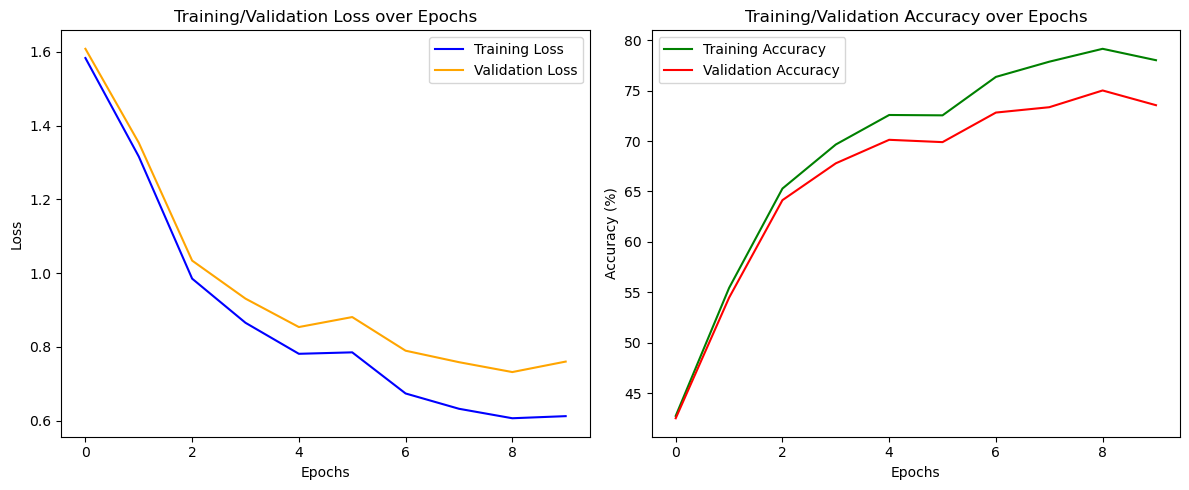

In [ ]:
model_resnet18_do.class_accuracy(valloader, model_resnet18_do.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do.plot_training_results()

In [ ]:
# Train the model with dropout
model_resnet18_do_2 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.5).to(device)
summary(model_resnet18_do_2, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_2.parameters(), lr=0.001)
num_epochs = 10

model_resnet18_do_2.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,864
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
    BasicBlock_DO-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Accuracy of plane : 54 %
Accuracy of   car : 61 %
Accuracy of  bird : 42 %
Accuracy of   cat : 20 %
Accuracy of  deer : 46 %
Accuracy of   dog : 78 %
Accuracy of  frog : 63 %
Accuracy of horse : 77 %
Accuracy of  ship : 82 %
Accuracy of truck : 84 %
Validation Accuracy: 61.04%


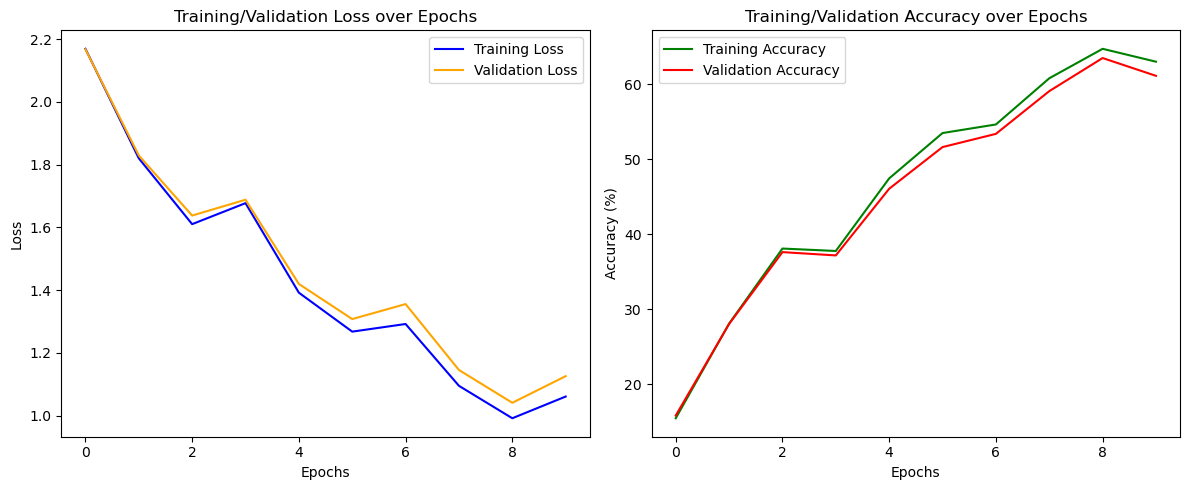

In [ ]:
model_resnet18_do_2.class_accuracy(valloader, model_resnet18_do_2.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_2.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_2.plot_training_results()

In [ ]:
model_resnet18_do_3 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.5).to(device)
summary(model_resnet18_do_3, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_3.parameters(), lr=0.001)
num_epochs = 30

model_resnet18_do_3.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,864
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
    BasicBlock_DO-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 52 %
Accuracy of   cat : 75 %
Accuracy of  deer : 74 %
Accuracy of   dog : 46 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 93 %
Validation Accuracy: 74.98%


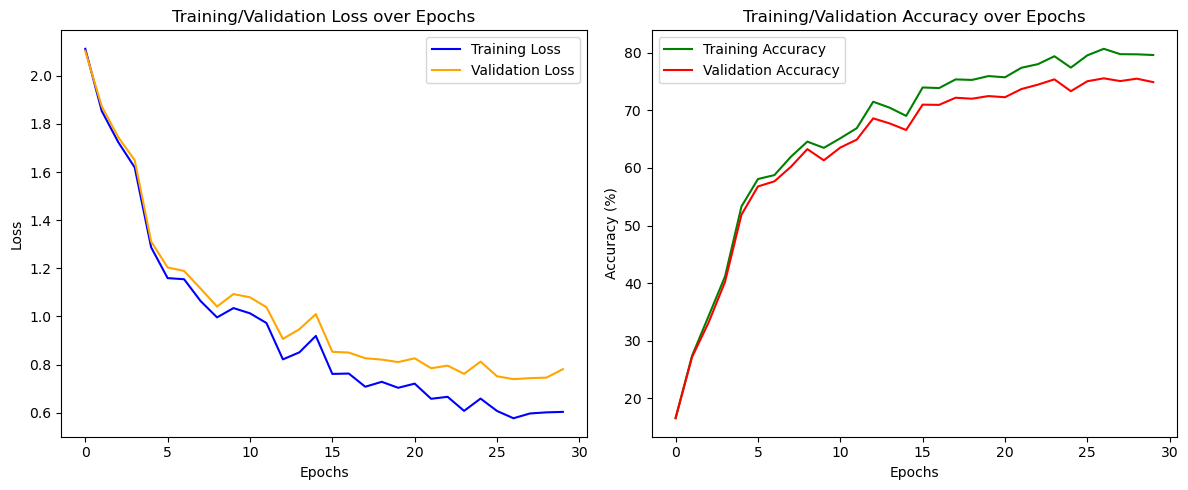

In [ ]:
model_resnet18_do_3.class_accuracy(valloader, model_resnet18_do_3.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_3.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_3.plot_training_results()

In [ ]:
batch_size = 64
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


model_resnet18_do_4 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do_4, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_4.parameters(), lr=0.001)
num_epochs = 30

model_resnet18_do_4.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,864
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
    BasicBlock_DO-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Accuracy of plane : 80 %
Accuracy of   car : 81 %
Accuracy of  bird : 77 %
Accuracy of   cat : 66 %
Accuracy of  deer : 81 %
Accuracy of   dog : 73 %
Accuracy of  frog : 87 %
Accuracy of horse : 79 %
Accuracy of  ship : 89 %
Accuracy of truck : 90 %
Validation Accuracy: 80.83%


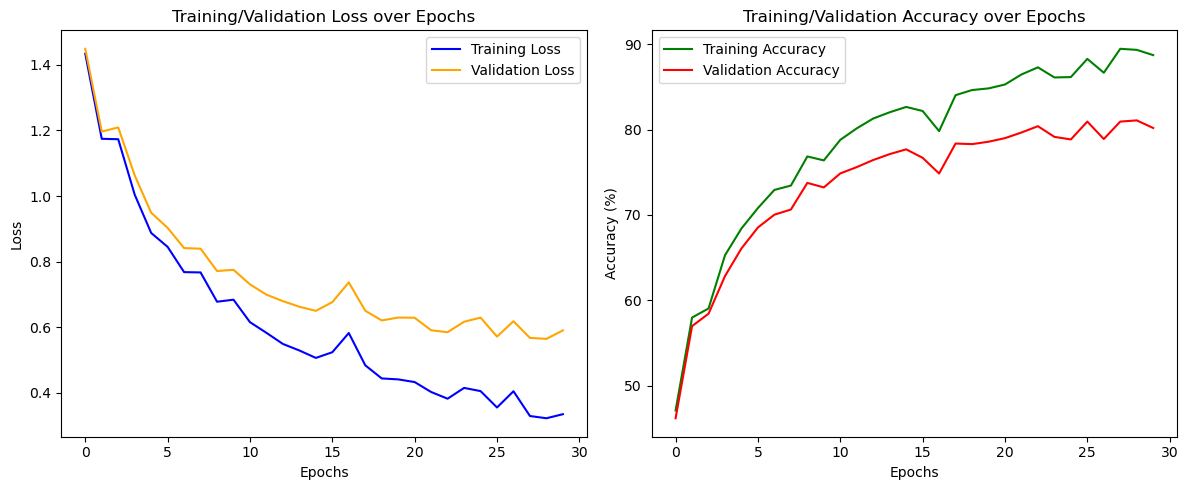

In [ ]:
model_resnet18_do_4.class_accuracy(valloader, model_resnet18_do_4.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_4.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_4.plot_training_results()


In [ ]:
trainloader, valloader, test_loader = set_batch_size(32)
model_resnet18_do_5 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_5.parameters(), lr=0.001)
num_epochs = 30

model_resnet18_do_5.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


{'Epoch': 1, 'Train_Loss': 1.6688986881256103, 'Train_Acc': 36.135, 'Val_Acc': 35.08, 'Val_Loss': 1.674866460382748}
{'Epoch': 2, 'Train_Loss': 1.3964441658496856, 'Train_Acc': 48.04, 'Val_Acc': 47.01, 'Val_Loss': 1.4158112370548919}
{'Epoch': 3, 'Train_Loss': 1.3252520256042482, 'Train_Acc': 52.015, 'Val_Acc': 51.15, 'Val_Loss': 1.3563196386772984}
{'Epoch': 4, 'Train_Loss': 1.211465818309784, 'Train_Acc': 57.405, 'Val_Acc': 56.52, 'Val_Loss': 1.2477275245486739}
{'Epoch': 5, 'Train_Loss': 1.0884661816120147, 'Train_Acc': 62.02, 'Val_Acc': 60.81, 'Val_Loss': 1.1259363619283365}
{'Epoch': 6, 'Train_Loss': 0.9952398995161057, 'Train_Acc': 65.2025, 'Val_Acc': 63.31, 'Val_Loss': 1.048896270057264}
{'Epoch': 7, 'Train_Loss': 0.9488592738628387, 'Train_Acc': 66.3575, 'Val_Acc': 64.7, 'Val_Loss': 1.0007994601520867}
{'Epoch': 8, 'Train_Loss': 0.8958001778125763, 'Train_Acc': 68.69, 'Val_Acc': 66.87, 'Val_Loss': 0.949505474811164}
{'Epoch': 9, 'Train_Loss': 0.9014712320566177, 'Train_Acc': 68

Accuracy of plane : 75 %
Accuracy of   car : 87 %
Accuracy of  bird : 72 %
Accuracy of   cat : 66 %
Accuracy of  deer : 75 %
Accuracy of   dog : 59 %
Accuracy of  frog : 76 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 87 %
Validation Accuracy: 78.05%


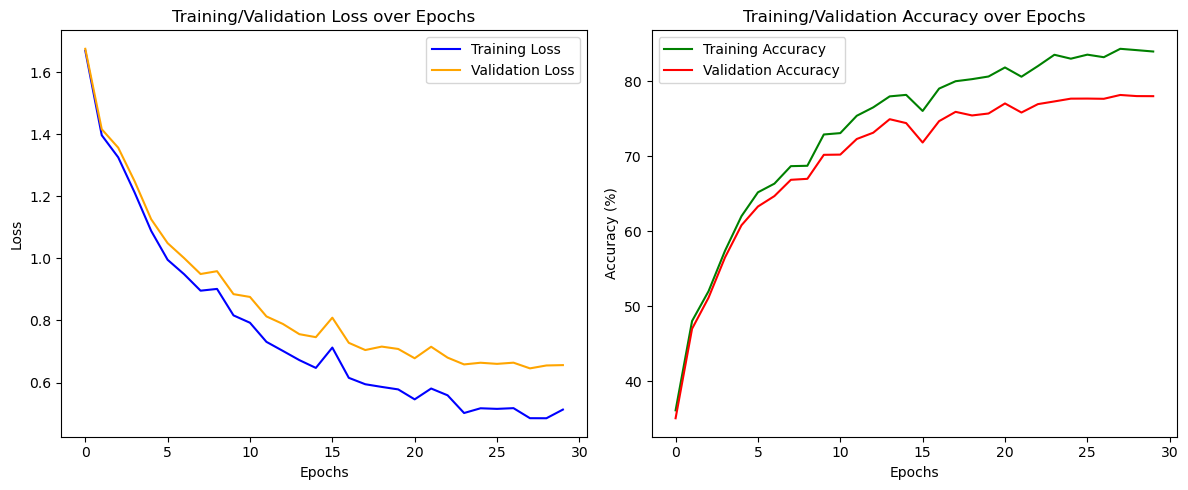

In [ ]:
model_resnet18_do_5.class_accuracy(valloader, model_resnet18_do_5.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_5.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_5.plot_training_results()

In [ ]:
model_resnet18_do_6 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do_6, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18_do_6.parameters(), lr=0.01, momentum=0.9)
num_epochs = 50

model_resnet18_do_6.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,864
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,864
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
    BasicBlock_DO-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Accuracy of plane : 82 %
Accuracy of   car : 85 %
Accuracy of  bird : 68 %
Accuracy of   cat : 69 %
Accuracy of  deer : 82 %
Accuracy of   dog : 64 %
Accuracy of  frog : 86 %
Accuracy of horse : 81 %
Accuracy of  ship : 91 %
Accuracy of truck : 89 %
Validation Accuracy: 80.62%


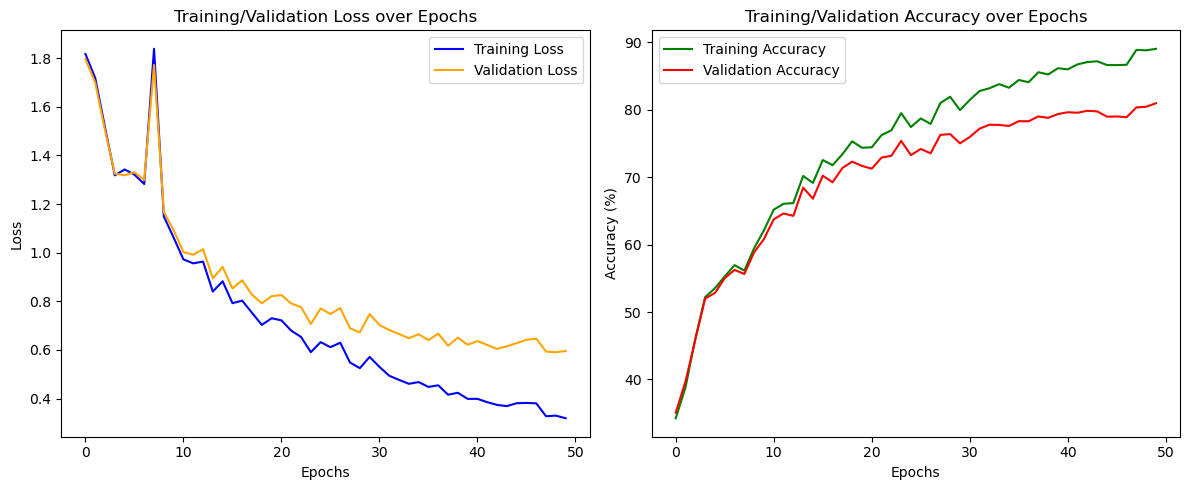

In [ ]:
model_resnet18_do_6.class_accuracy(valloader, model_resnet18_do_6.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_6.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_6.plot_training_results()


In [ ]:
# Load model_resnet18_do_6
model_resnet18_do_6 = ResNet18Trainer_DO(num_classes=10, dropout_rate=0.3).to(device)
model_resnet18_do_6.load_state_dict(torch.load('model_resnet18_do_6.pth'))
model_resnet18_do_6.eval()

model_resnet18_do_6.class_accuracy(valloader, model_resnet18_do_6.classes)

Accuracy of plane : 89 %
Accuracy of   car : 88 %
Accuracy of  bird : 77 %
Accuracy of   cat : 72 %
Accuracy of  deer : 92 %
Accuracy of   dog : 78 %
Accuracy of  frog : 91 %
Accuracy of horse : 94 %
Accuracy of  ship : 97 %
Accuracy of truck : 94 %


In [ ]:
# Resnet + dropout layer
class BasicBlock_DO_mod(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(BasicBlock_DO_mod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        out = self.dropout(out)  # Apply dropout after the residual connection

        return out

class ResNet18Trainer_DO_mod(ModelTrainer):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet18Trainer_DO_mod, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(BasicBlock_DO_mod, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlock_DO_mod, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlock_DO_mod, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlock_DO_mod, 512, 2, stride=2, dropout_rate=dropout_rate)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock_DO_mod.expansion, num_classes)

        # Final dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply final dropout before the output layer
        return self.fc(x)


In [ ]:
model_resnet18_do_mod = ResNet18Trainer_DO_mod(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do_mod, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_mod.parameters(), lr=0.001)
num_epochs = 30

model_resnet18_do_mod.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
          Dropout-10           [-1, 64, 16, 16]               0
BasicBlock_DO_mod-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 71 %
Accuracy of  deer : 86 %
Accuracy of   dog : 77 %
Accuracy of  frog : 94 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 90 %
Validation Accuracy: 87.20%


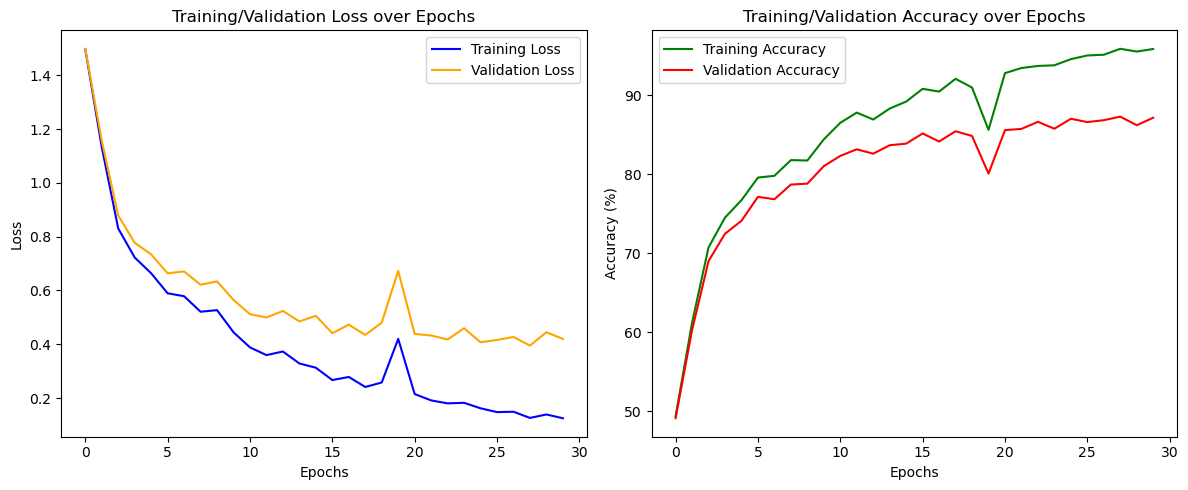

In [ ]:
model_resnet18_do_mod.class_accuracy(valloader, model_resnet18_do_mod.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_mod.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_mod.plot_training_results()


In [ ]:
# Try resnet18_do_mod with SGD
model_resnet18_do_mod_sgd = ResNet18Trainer_DO_mod(num_classes=10, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18_do_mod_sgd.parameters(), lr=0.001, momentum=0.9)
num_epochs = 30

model_resnet18_do_mod_sgd.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


{'Epoch': 1, 'Train_Loss': 1.8129128469064975, 'Train_Acc': 38.3725, 'Val_Acc': 37.47, 'Val_Loss': 1.8413300272784656}
{'Epoch': 2, 'Train_Loss': 1.6022009575328888, 'Train_Acc': 46.87, 'Val_Acc': 45.88, 'Val_Loss': 1.6443315321886087}
{'Epoch': 3, 'Train_Loss': 1.3785270840976946, 'Train_Acc': 52.94, 'Val_Acc': 51.72, 'Val_Loss': 1.4266602661036238}
{'Epoch': 4, 'Train_Loss': 1.0628402968184254, 'Train_Acc': 62.1875, 'Val_Acc': 60.26, 'Val_Loss': 1.1080878527858589}
{'Epoch': 5, 'Train_Loss': 0.9927420031529265, 'Train_Acc': 65.325, 'Val_Acc': 63.83, 'Val_Loss': 1.0491322610951677}
{'Epoch': 6, 'Train_Loss': 0.9864957802973616, 'Train_Acc': 65.9475, 'Val_Acc': 64.08, 'Val_Loss': 1.0465762622748749}
{'Epoch': 7, 'Train_Loss': 1.3043449806710021, 'Train_Acc': 57.445, 'Val_Acc': 56.0, 'Val_Loss': 1.374441973770721}
{'Epoch': 8, 'Train_Loss': 0.8683202994136384, 'Train_Acc': 70.2125, 'Val_Acc': 67.58, 'Val_Loss': 0.9473062270804297}
{'Epoch': 9, 'Train_Loss': 0.9171990784593284, 'Train_Ac

In [ ]:
model_resnet18_do_mod_sgd.class_accuracy(valloader, model_resnet18_do_mod_sgd.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_mod_sgd.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_mod_sgd.plot_training_results()

Accuracy of plane : 84 %
Accuracy of   car : 90 %
Accuracy of  bird : 75 %
Accuracy of   cat : 59 %
Accuracy of  deer : 83 %
Accuracy of   dog : 81 %
Accuracy of  frog : 87 %
Accuracy of horse : 84 %
Accuracy of  ship : 91 %
Accuracy of truck : 88 %
Validation Accuracy: 82.57%


In [ ]:
# Try resnet18_do_mod with SGD wiht lr=0.01
model_resnet18_do_mod_sgd = ResNet18Trainer_DO_mod(num_classes=10, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18_do_mod_sgd.parameters(), lr=0.01, momentum=0.9)
num_epochs = 30

model_resnet18_do_mod_sgd.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


{'Epoch': 1, 'Train_Loss': 1.736430579100173, 'Train_Acc': 41.765, 'Val_Acc': 41.12, 'Val_Loss': 1.7477850400948827}
{'Epoch': 2, 'Train_Loss': 1.2065322932343894, 'Train_Acc': 56.36, 'Val_Acc': 56.59, 'Val_Loss': 1.2131357630596886}
{'Epoch': 3, 'Train_Loss': 1.1429042182029627, 'Train_Acc': 60.465, 'Val_Acc': 59.87, 'Val_Loss': 1.1672957094409797}
{'Epoch': 4, 'Train_Loss': 1.0213618712684216, 'Train_Acc': 63.185, 'Val_Acc': 62.81, 'Val_Loss': 1.0640157129191146}
{'Epoch': 5, 'Train_Loss': 0.8173359697238325, 'Train_Acc': 71.1975, 'Val_Acc': 69.3, 'Val_Loss': 0.867852158184293}
{'Epoch': 6, 'Train_Loss': 0.7549225343302035, 'Train_Acc': 73.6825, 'Val_Acc': 72.25, 'Val_Loss': 0.8051907812492757}
{'Epoch': 7, 'Train_Loss': 0.7341358948249025, 'Train_Acc': 74.6075, 'Val_Acc': 72.08, 'Val_Loss': 0.8033036921597734}
{'Epoch': 8, 'Train_Loss': 0.6022162402209382, 'Train_Acc': 78.93, 'Val_Acc': 76.63, 'Val_Loss': 0.6866948778116251}
{'Epoch': 9, 'Train_Loss': 0.5609859575669225, 'Train_Acc'

Accuracy of plane : 82 %
Accuracy of   car : 90 %
Accuracy of  bird : 81 %
Accuracy of   cat : 64 %
Accuracy of  deer : 86 %
Accuracy of   dog : 78 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %
Validation Accuracy: 85.68%


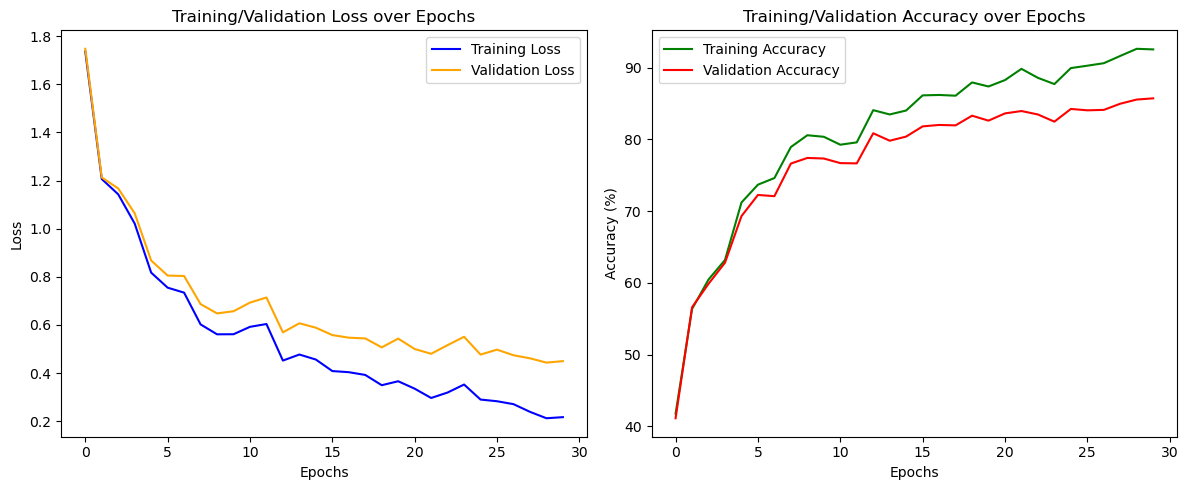

In [ ]:
model_resnet18_do_mod_sgd.class_accuracy(valloader, model_resnet18_do_mod_sgd.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_mod_sgd.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_resnet18_do_mod_sgd.plot_training_results()


In [ ]:
# Try resnet18_do_mod with learning rate scheduler

from torch.optim.lr_scheduler import StepLR

class ModelTrainer_LR_sched(ModelTrainer):
    def train_network(self, trainloader, valloader, num_epochs, criterion, optimizer, scheduler=None):
        start_time = time.time()
        training_stats = []
        self.epochs = num_epochs
        self.stats_list = []
        early_stop = EarlyStopping(patience=2, min_delta=1)

        for epoch in range(0, num_epochs):
            self.train()
            batch_loss, batch_acc = [], []
            for i, batch_data in enumerate(trainloader, 0):
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                predictions = self(inputs)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()

            # Step the scheduler if it's provided
            if scheduler is not None:
                scheduler.step()

            train_acc, train_loss = self.compute_acc_and_loss(trainloader, criterion)
            val_acc, val_loss = self.compute_acc_and_loss(valloader, criterion, mode="val")

            if early_stop.should_stop(val_loss):
                break

            epoch_stat = {"Epoch": epoch + 1, "Train_Loss": train_loss, "Train_Acc": train_acc, "Val_Acc": val_acc, "Val_Loss": val_loss}
            print(epoch_stat)
            training_stats.append(epoch_stat)

            # Save checkpoint periodically (optional)
            #if epoch % 2 == 0 and epoch > 0:
            #    elapsed_time = time.time() - start_time
             #   save_checkpoint(self, optimizer, epoch, training_stats, elapsed_time)

        self.stats_list = training_stats
        print('Training Completed')
        print(f"Total Time: {round((time.time() - start_time) / 60, 2)} minutes")


# Resnet + dropout layer
class BasicBlock_DO_mod(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(BasicBlock_DO_mod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        out = self.dropout(out)  # Apply dropout after the residual connection

        return out

class ResNet18Trainer_DO_mod_LR_sched(ModelTrainer_LR_sched):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet18Trainer_DO_mod_LR_sched, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(BasicBlock_DO_mod, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlock_DO_mod, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlock_DO_mod, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlock_DO_mod, 512, 2, stride=2, dropout_rate=dropout_rate)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock_DO_mod.expansion, num_classes)

        # Final dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply final dropout before the output layer
        return self.fc(x)


In [ ]:
model_resnet18_do_lr_sched = ResNet18Trainer_DO_mod_LR_sched(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do_lr_sched, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_lr_sched.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 30

model_resnet18_do_lr_sched.train_network(trainloader, valloader, num_epochs, criterion, optimizer, scheduler)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
          Dropout-10           [-1, 64, 16, 16]               0
BasicBlock_DO_mod-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Accuracy of plane : 81 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 60 %
Accuracy of  deer : 73 %
Accuracy of   dog : 62 %
Accuracy of  frog : 83 %
Accuracy of horse : 76 %
Accuracy of  ship : 87 %
Accuracy of truck : 82 %
Validation Accuracy: 77.22%


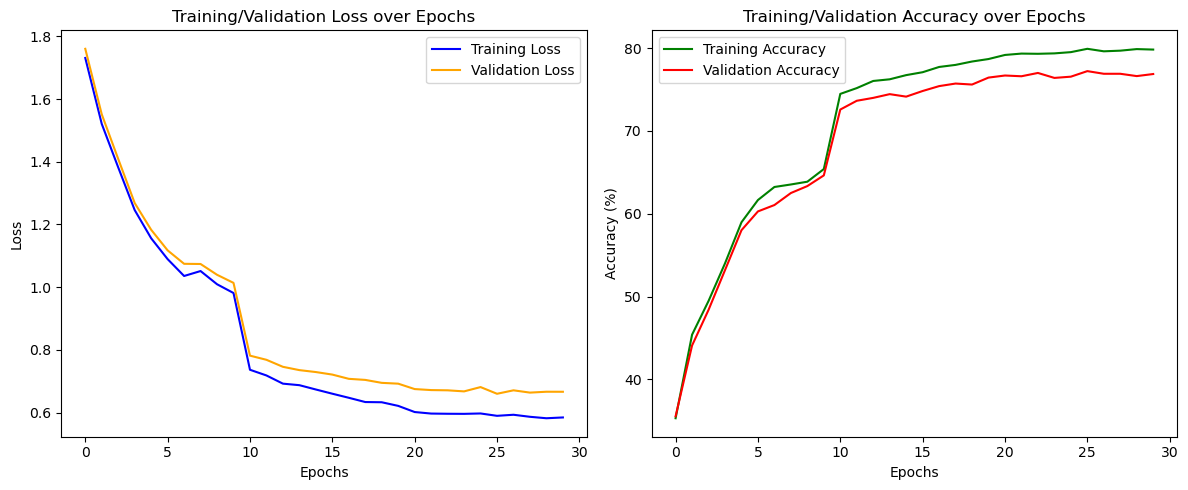

In [ ]:
model_resnet18_do_lr_sched.class_accuracy(valloader, model_resnet18_do_lr_sched.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_lr_sched.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")

model_resnet18_do_lr_sched.plot_training_results()
#model_resnet18_do_lr_sched.save_model('model_resnet18_do_lr_sched.pth')

In [ ]:
# try resnet18_do_lr_sched with OneCycleLR
from torch.optim.lr_scheduler import OneCycleLR

class ResNet18Trainer_DO_mod_LR_sched_OneCycle(ModelTrainer):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet18Trainer_DO_mod_LR_sched_OneCycle, self).__init__()
        self.in_channels = 64

        # Initial convolution and max pooling layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-18 layers
        self.layer1 = self._make_layer(BasicBlock_DO_mod, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(BasicBlock_DO_mod, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(BasicBlock_DO_mod, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(BasicBlock_DO_mod, 512, 2, stride=2, dropout_rate=dropout_rate)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock_DO_mod.expansion, num_classes)

        # Final dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def _make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Pass through each layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Apply final dropout before the output layer
        return self.fc(x)

    def train_network(self, trainloader, valloader, num_epochs, criterion, optimizer, scheduler=None):
        start_time = time.time()
        training_stats = []
        self.epochs = num_epochs
        self.stats_list = []
        early_stop = EarlyStopping(patience=2, min_delta=1)

        for epoch in range(0, num_epochs):
            self.train()
            batch_loss, batch_acc = [], []
            for i, batch_data in enumerate(trainloader, 0):
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                predictions = self(inputs)
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()

            # Step the scheduler if it's provided
            if scheduler is not None:
                scheduler.step()

            train_acc, train_loss = self.compute_acc_and_loss(trainloader, criterion)
            val_acc, val_loss = self.compute_acc_and_loss(valloader, criterion, mode="val")

            if early_stop.should_stop(val_loss):
                break

            epoch_stat = {"Epoch": epoch + 1, "Train_Loss": train_loss, "Train_Acc": train_acc, "Val_Acc": val_acc, "Val_Loss": val_loss}
            # print learning rate
            print(f"Epoch: {epoch + 1}, LR: {scheduler.get_last_lr()}")
            print(epoch_stat)
            training_stats.append(epoch_stat)

            # Save checkpoint periodically (optional)
            #if epoch % 2 == 0 and epoch > 0:
            #    elapsed_time = time.time() - start_time
             #   save_checkpoint(self, optimizer, epoch, training_stats, elapsed_time)

        self.stats_list = training_stats
        print('Training Completed')
        print(f"Total Time: {round((time.time() - start_time) / 60, 2)} minutes")

model_resnet18_do_lr_sched_onecycle = ResNet18Trainer_DO_mod_LR_sched_OneCycle(num_classes=10, dropout_rate=0.3).to(device)
summary(model_resnet18_do_lr_sched_onecycle, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18_do_lr_sched_onecycle.parameters(), lr=0.01)
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=30)
num_epochs = 30

model_resnet18_do_lr_sched_onecycle.train_network(trainloader, valloader, num_epochs, criterion, optimizer, scheduler)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,864
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
          Dropout-10           [-1, 64, 16, 16]               0
BasicBlock_DO_mod-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Accuracy of plane : 77 %
Accuracy of   car : 88 %
Accuracy of  bird : 52 %
Accuracy of   cat : 76 %
Accuracy of  deer : 77 %
Accuracy of   dog : 38 %
Accuracy of  frog : 79 %
Accuracy of horse : 74 %
Accuracy of  ship : 91 %
Accuracy of truck : 82 %
Validation Accuracy: 74.12%


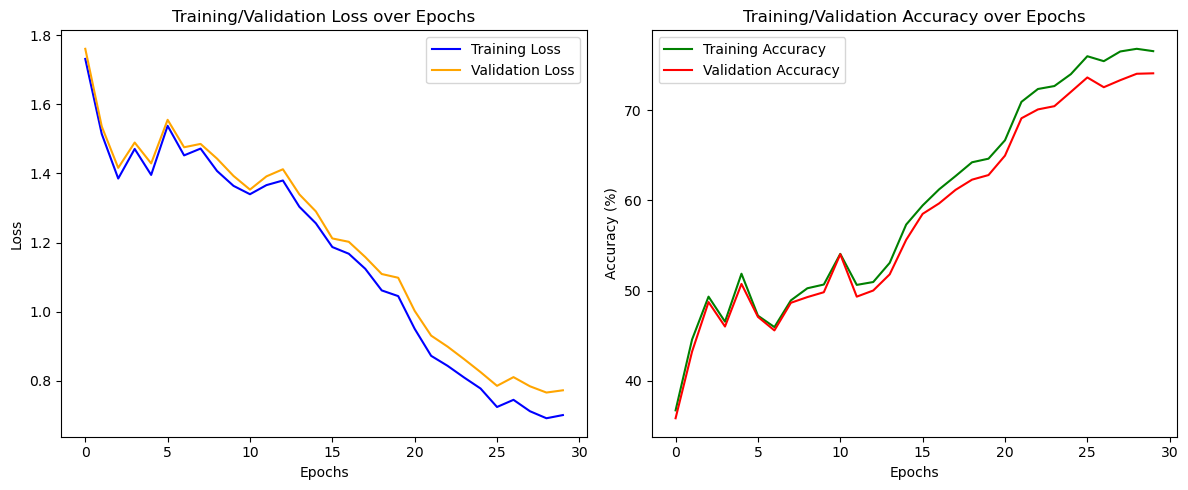

In [ ]:
model_resnet18_do_lr_sched_onecycle.class_accuracy(valloader, model_resnet18_do_lr_sched_onecycle.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_resnet18_do_lr_sched_onecycle.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")

model_resnet18_do_lr_sched_onecycle.plot_training_results()


In [ ]:
# save all model resnet_18 (not the checkpoint)
torch.save(model_resnet18.state_dict(), 'model_resnet18.pth')
torch.save(model_resnet18_sgd.state_dict(), 'model_resnet18_sgd.pth')
torch.save(model_resnet18_do.state_dict(), 'model_resnet18_do.pth')
torch.save(model_resnet18_do_2.state_dict(), 'model_resnet18_do_2.pth')
torch.save(model_resnet18_do_3.state_dict(), 'model_resnet18_do_3.pth')
torch.save(model_resnet18_do_4.state_dict(), 'model_resnet18_do_4.pth')
torch.save(model_resnet18_do_5.state_dict(), 'model_resnet18_do_5.pth')


In [ ]:
# save model do_6
torch.save(model_resnet18_do_6.state_dict(), 'model_resnet18_do_6.pth')

#### MOBILENET

In [ ]:
# import models
from torchvision import models
# Train mobilenet from scratch
class MobileNetV2(ModelTrainer):
    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        self.model.classifier[1] = nn.Linear(1280, num_classes)
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def forward(self, x):
        return self.model(x)

model_mobilenet = MobileNetV2(num_classes=10).to(device)
summary(model_mobilenet, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenet.parameters(), lr=0.001)
num_epochs = 20

model_mobilenet.train_network(trainloader, valloader, num_epochs, criterion, optimizer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

Accuracy of plane : 78 %
Accuracy of   car : 76 %
Accuracy of  bird : 54 %
Accuracy of   cat : 50 %
Accuracy of  deer : 71 %
Accuracy of   dog : 61 %
Accuracy of  frog : 69 %
Accuracy of horse : 78 %
Accuracy of  ship : 79 %
Accuracy of truck : 84 %
Validation Accuracy: 70.50%


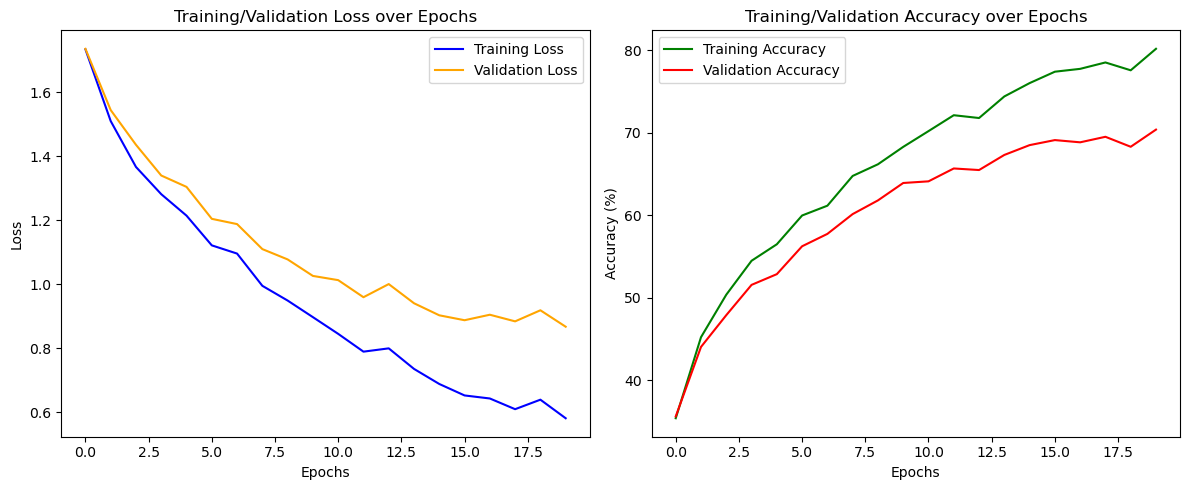

In [ ]:
model_mobilenet.class_accuracy(valloader, model_mobilenet.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_mobilenet.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_mobilenet.plot_training_results()


In [ ]:
# train model mobilenetv3 large
class MobileNetV3Large(ModelTrainer):
    def __init__(self, num_classes=10):
        super(MobileNetV3Large, self).__init__()
        self.model = models.mobilenet_v3_large(pretrained=False)
        self.model.classifier[3] = nn.Linear(1280, num_classes)
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def forward(self, x):
        return self.model(x)

model_mobilenetv3_large = MobileNetV3Large(num_classes=10).to(device)
summary(model_mobilenetv3_large, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv3_large.parameters(), lr=0.001)
num_epochs = 20

model_mobilenetv3_large.train_network(trainloader, valloader, num_epochs, criterion, optimizer)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             432
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         Hardswish-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             144
       BatchNorm2d-5           [-1, 16, 16, 16]              32
              ReLU-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             256
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           1,024
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]             576
      BatchNorm2d-14             [-1, 6

Accuracy of plane : 64 %
Accuracy of   car : 80 %
Accuracy of  bird : 60 %
Accuracy of   cat : 53 %
Accuracy of  deer : 67 %
Accuracy of   dog : 58 %
Accuracy of  frog : 77 %
Accuracy of horse : 77 %
Accuracy of  ship : 88 %
Accuracy of truck : 80 %
Validation Accuracy: 71.41%


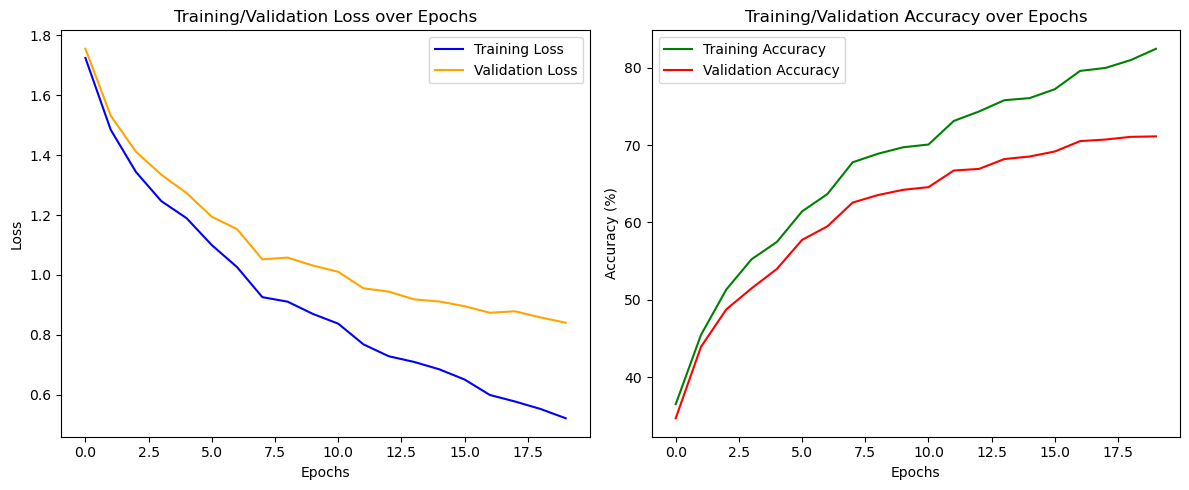

In [ ]:
model_mobilenet.class_accuracy(valloader, model_mobilenet.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_mobilenet.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_mobilenet.plot_training_results()



Accuracy of plane : 70 %
Accuracy of   car : 80 %
Accuracy of  bird : 55 %
Accuracy of   cat : 53 %
Accuracy of  deer : 58 %
Accuracy of   dog : 57 %
Accuracy of  frog : 79 %
Accuracy of horse : 69 %
Accuracy of  ship : 83 %
Accuracy of truck : 74 %
Validation Accuracy: 68.84%


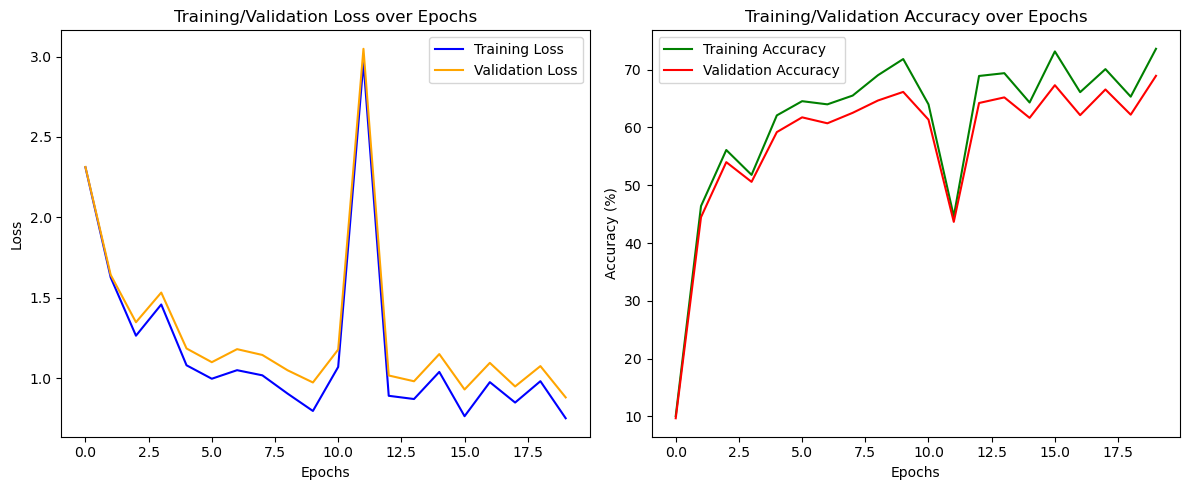

In [ ]:
model_mobilenetv3_large.class_accuracy(valloader, model_mobilenetv3_large.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_mobilenetv3_large.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_mobilenetv3_large.plot_training_results()


#### EFFICIENTNET

In [ ]:
# load model efficientnet (not pretrained)
from efficientnet_pytorch import EfficientNet
class EfficientNetB0(ModelTrainer):
    def __init__(self, num_classes=10):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def forward(self, x):
        return self.model(x)

model_efficientnet = EfficientNetB0(num_classes=10).to(device)
summary(model_efficientnet, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=0.001)
num_epochs = 20

model_efficientnet.train_network(trainloader, valloader, num_epochs, criterion, optimizer)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 33, 33]               0
Conv2dStaticSamePadding-2           [-1, 32, 16, 16]             864
       BatchNorm2d-3           [-1, 32, 16, 16]              64
MemoryEfficientSwish-4           [-1, 32, 16, 16]               0
         ZeroPad2d-5           [-1, 32, 18, 18]               0
Conv2dStaticSamePadding-6           [-1, 32, 16, 16]             288
       BatchNorm2d-7           [-1, 32, 16, 16]              64
MemoryEfficientSwish-8           [-1, 32, 16, 16]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

Accuracy of plane : 78 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 45 %
Accuracy of  deer : 59 %
Accuracy of   dog : 66 %
Accuracy of  frog : 75 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 74 %
Validation Accuracy: 72.84%


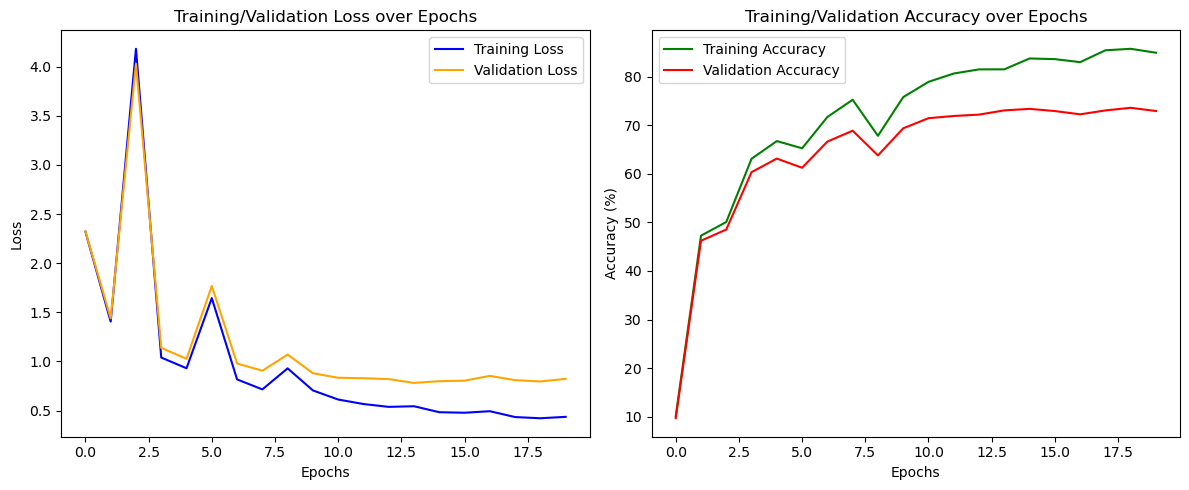

In [ ]:
model_efficientnet.class_accuracy(valloader, model_efficientnet.classes)
# Calculate total accuracy for validation set
val_acc, val_loss = model_efficientnet.compute_acc_and_loss(valloader, criterion, mode="val")
print(f"Validation Accuracy: {val_acc:.2f}%")
model_efficientnet.plot_training_results()


In [ ]:
# save trained model resnet, mobilenet, mobilenetv3, efficientnet
torch.save(model_resnet18_do_6.state_dict(), 'model_resnet18.pth')
torch.save(model_resnet18_do_mod.state_dict(), 'model_resnet18_do_mod.pth')
torch.save(model_resnet18_do_mod_sgd.state_dict(), 'model_resnet18_do_mod_sgd.pth')
torch.save(model_efficientnet.state_dict(), 'model_efficientnet.pth')
torch.save(model_mobilenet.state_dict(), 'model_mobilenet.pth')
torch.save(model_mobilenetv3_large.state_dict(), 'model_mobilenetv3_large.pth')



### SUMMARY

Accuracy of the network on the test data: 84.83%


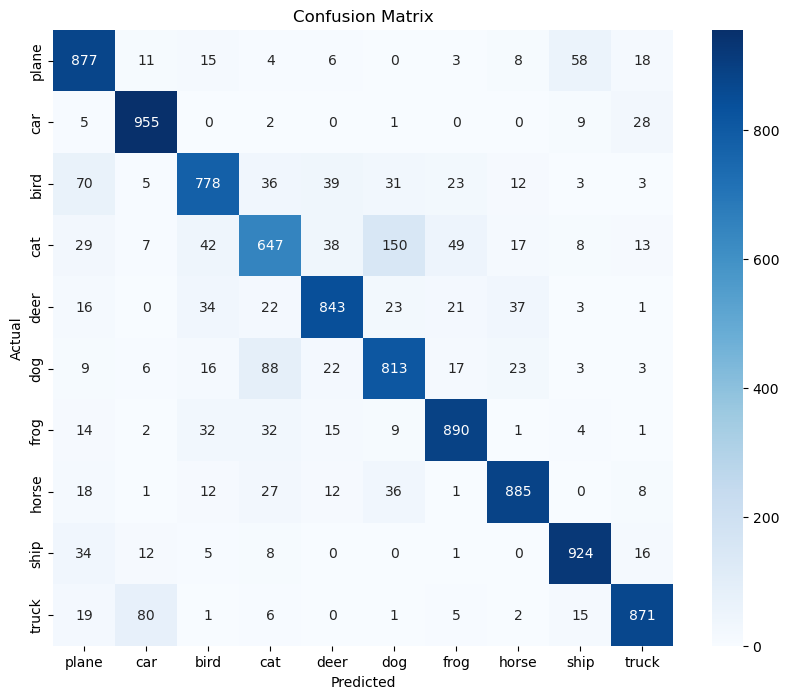

In [ ]:
# test the model with test data
predictions_list, accuracy = model_resnet18_do_mod.predict(test_loader)
plot_confusion_matrix(test_dataset.targets, predictions_list, model_resnet18_do_mod.classes)

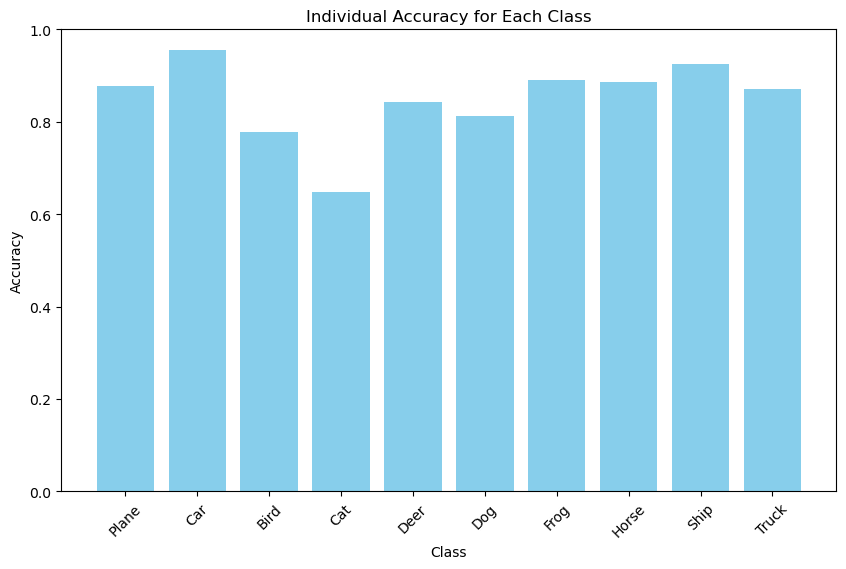

In [ ]:
# Calculating individual accuracy for each class based on confusion matrix values

# True Positives and Total Instances for each class
true_positives = [877, 955, 778, 647, 843, 813, 890, 885, 924, 871]
total_instances = [
    877 + 11 + 15 + 4 + 6 + 0 + 3 + 8 + 58 + 18,   # Plane
    5 + 955 + 0 + 2 + 0 + 1 + 0 + 0 + 9 + 28,       # Car
    70 + 5 + 778 + 36 + 39 + 31 + 23 + 12 + 3 + 3,  # Bird
    29 + 7 + 42 + 647 + 38 + 150 + 49 + 17 + 8 + 13, # Cat
    16 + 0 + 34 + 22 + 843 + 23 + 21 + 37 + 3 + 1,  # Deer
    9 + 6 + 16 + 88 + 22 + 813 + 17 + 23 + 3 + 3,   # Dog
    14 + 2 + 32 + 32 + 15 + 9 + 890 + 1 + 4 + 1,    # Frog
    18 + 1 + 12 + 27 + 12 + 36 + 1 + 885 + 0 + 8,   # Horse
    34 + 12 + 5 + 8 + 0 + 0 + 1 + 0 + 924 + 16,     # Ship
    19 + 80 + 1 + 6 + 0 + 1 + 5 + 2 + 15 + 871      # Truck
]

# Calculating individual accuracies
accuracies = [tp / total for tp, total in zip(true_positives, total_instances)]

import matplotlib.pyplot as plt

# Class labels
class_labels = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Plotting the individual accuracies for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Individual Accuracy for Each Class')
plt.ylim(0, 1)  # Setting y-axis to represent accuracy as percentage
plt.xticks(rotation=45)
plt.show()

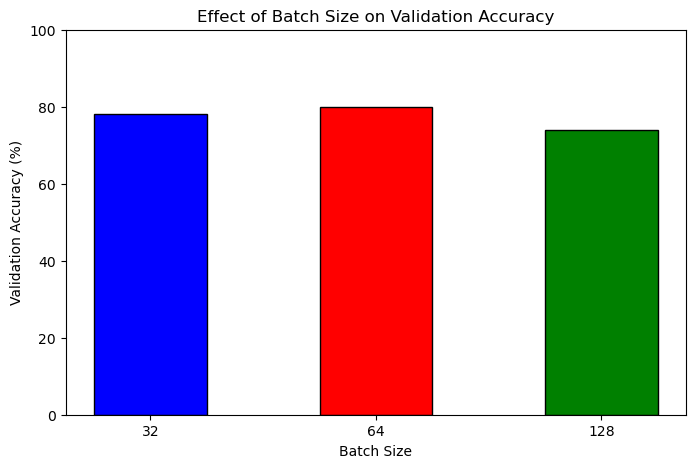

In [ ]:
import matplotlib.pyplot as plt

# Data
batch_sizes = ['32', '64', '128']  # Batch sizes as strings for categorical x-axis
validation_accuracies = [78, 80, 74]
colors = ['blue', 'red', 'green']  # Solid colors for each bar

# Plot
plt.figure(figsize=(8, 5))
plt.bar(batch_sizes, validation_accuracies, color=colors, width=0.5, edgecolor='black')  # Solid colors with black edges
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy (%)')
plt.title('Effect of Batch Size on Validation Accuracy')
plt.ylim(0, 100)
plt.show()
